In [1]:
import pandas as pd
import matplotlib.pyplot as plt

consultation = pd.read_csv('data/nhs/Consultation.csv')
ae_quality = pd.read_csv('data/nhs/AE_Quality_Index.csv')

consultation['date'] = pd.to_datetime(consultation['CALENDAR_MONTH_END_DATE'], format='%b-%y')
consultation = consultation.sort_values('date')
ae_quality['date'] = pd.to_datetime(ae_quality['ATTENDANCE_MONTH'])


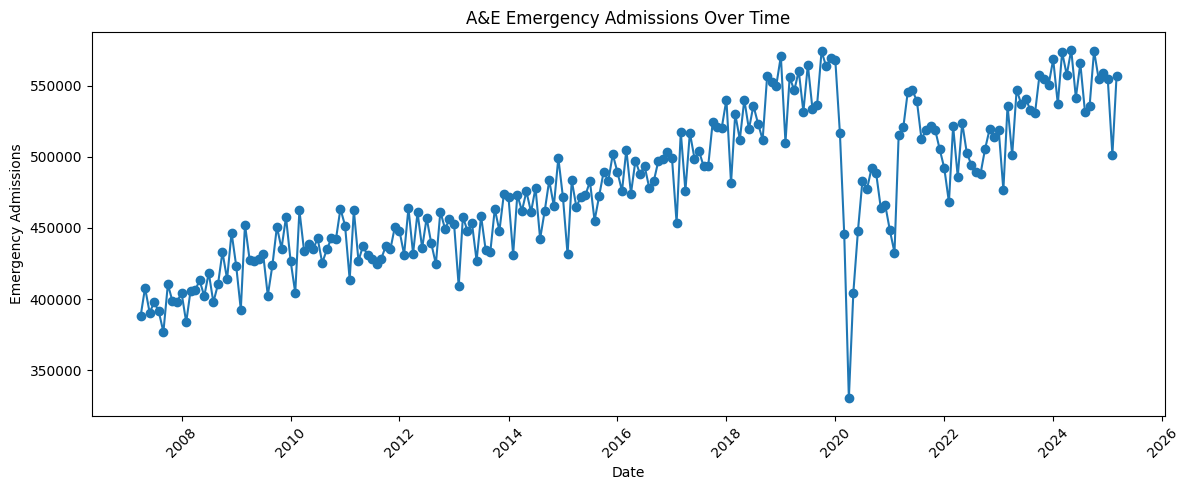

In [2]:
# A&E Activity over time
plt.figure(figsize=(12, 5))
plt.plot(consultation['date'], consultation['APC_Emergency'], marker='o')
plt.title('A&E Emergency Admissions Over Time')
plt.xlabel('Date')
plt.ylabel('Emergency Admissions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


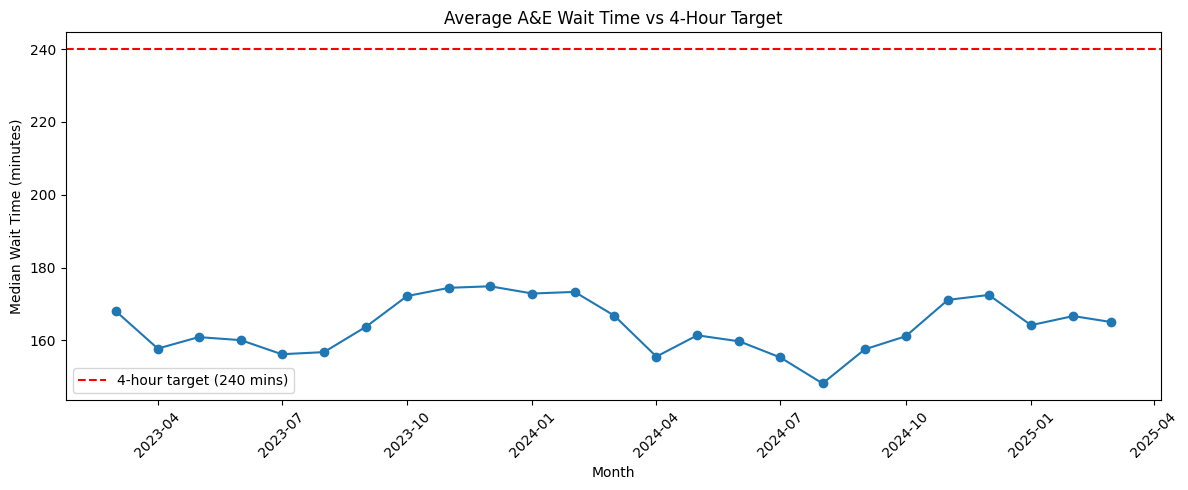

In [3]:
# 4-hour target analysis
wait_times = ae_quality[ae_quality['MEASURE_NAME'] == 'TOTAL_TIME_MEDIAN'].copy()
wait_times_monthly = wait_times.groupby('date')['MEASURE_VALUE'].mean().reset_index()

plt.figure(figsize=(12, 5))
plt.plot(wait_times_monthly['date'], wait_times_monthly['MEASURE_VALUE'], marker='o')
plt.axhline(y=240, color='r', linestyle='--', label='4-hour target (240 mins)')
plt.title('Average A&E Wait Time vs 4-Hour Target')
plt.xlabel('Month')
plt.ylabel('Median Wait Time (minutes)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


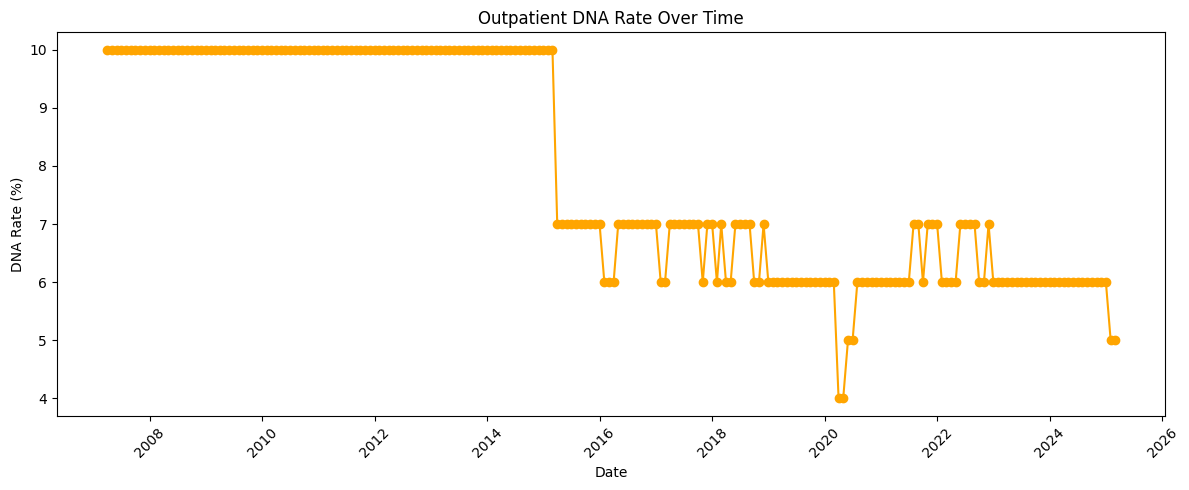

In [4]:
# DNA (Did Not Attend) Rate over time
plt.figure(figsize=(12, 5))
plt.plot(consultation['date'], consultation['Outpatient_Percent_DNA'] * 100, marker='o', color='orange')
plt.title('Outpatient DNA Rate Over Time')
plt.xlabel('Date')
plt.ylabel('DNA Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


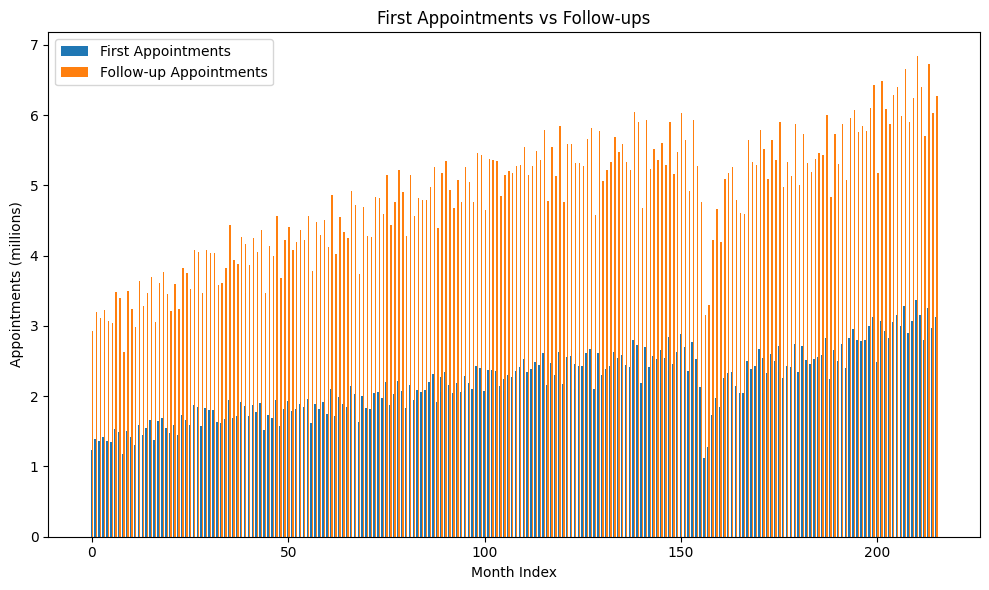

In [5]:
# Follow-ups vs First Appointments
plt.figure(figsize=(10, 6))
x = range(len(consultation))
width = 0.35
plt.bar([i - width/2 for i in x], consultation['Outpatient_Attendance_Type_1']/1e6, width, label='First Appointments')
plt.bar([i + width/2 for i in x], consultation['Outpatient_Attendance_Type_2']/1e6, width, label='Follow-up Appointments')
plt.xlabel('Month Index')
plt.ylabel('Appointments (millions)')
plt.title('First Appointments vs Follow-ups')
plt.legend()
plt.tight_layout()
plt.show()


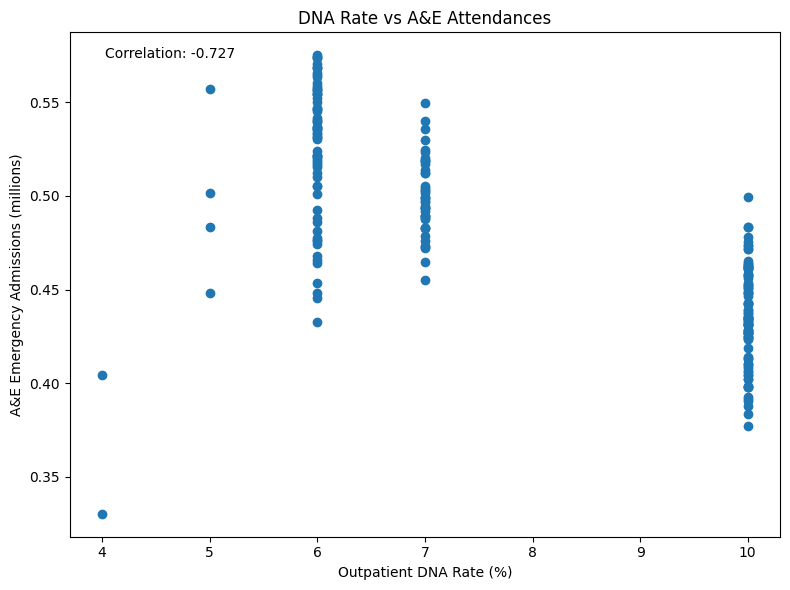

In [6]:
# Correlation: DNA rate vs A&E attendances
plt.figure(figsize=(8, 6))
plt.scatter(consultation['Outpatient_Percent_DNA'] * 100, consultation['APC_Emergency']/1e6)
plt.xlabel('Outpatient DNA Rate (%)')
plt.ylabel('A&E Emergency Admissions (millions)')
plt.title('DNA Rate vs A&E Attendances')

corr = consultation['Outpatient_Percent_DNA'].corr(consultation['APC_Emergency'])
plt.annotate(f'Correlation: {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction')
plt.tight_layout()
plt.show()


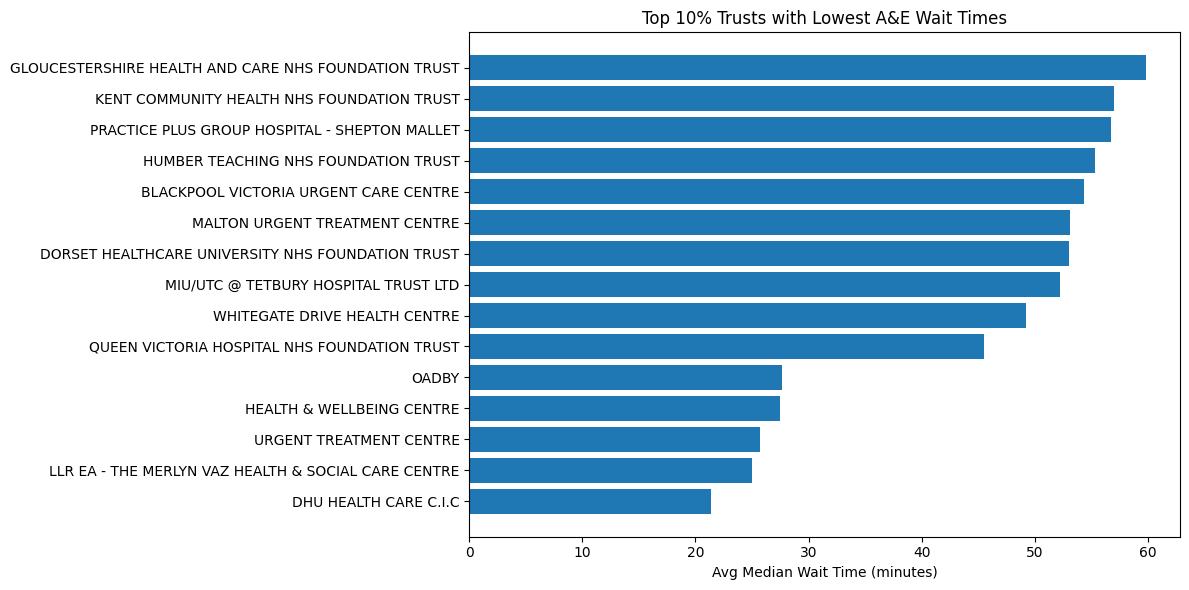

In [7]:
# Top 10% Trusts with lowest A&E wait times
wait_by_trust = ae_quality[ae_quality['MEASURE_NAME'] == 'TOTAL_TIME_MEDIAN'].groupby('ORG_NAME')['MEASURE_VALUE'].mean().reset_index()
wait_by_trust = wait_by_trust.sort_values('MEASURE_VALUE')

top_10_pct = int(len(wait_by_trust) * 0.1)
best_trusts = wait_by_trust.head(top_10_pct)

plt.figure(figsize=(12, 6))
plt.barh(best_trusts['ORG_NAME'][:15], best_trusts['MEASURE_VALUE'][:15])
plt.xlabel('Avg Median Wait Time (minutes)')
plt.title('Top 10% Trusts with Lowest A&E Wait Times')
plt.tight_layout()
plt.show()


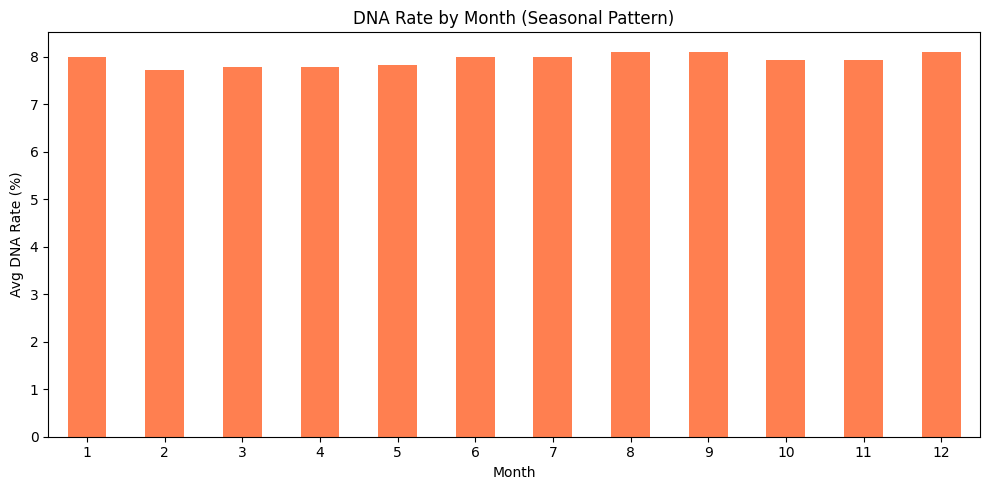

In [8]:
# DNA Rate by Month (seasonal trends)
consultation['month'] = consultation['date'].dt.month
monthly_dna = consultation.groupby('month')['Outpatient_Percent_DNA'].mean() * 100

plt.figure(figsize=(10, 5))
monthly_dna.plot(kind='bar', color='coral')
plt.xlabel('Month')
plt.ylabel('Avg DNA Rate (%)')
plt.title('DNA Rate by Month (Seasonal Pattern)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [9]:
avg_emergency = consultation['APC_Emergency'].mean()
avg_outpatient = consultation['Outpatient_Total_Appointments'].mean()
avg_attended = consultation['Outpatient_Attended_Appointments'].mean()

print(f"Average monthly A&E emergency admissions: {avg_emergency:,.0f}")
print(f"Average monthly outpatient appointments: {avg_outpatient:,.0f}")
print(f"Average monthly attended appointments: {avg_attended:,.0f}")


Average monthly A&E emergency admissions: 478,644
Average monthly outpatient appointments: 8,966,790
Average monthly attended appointments: 7,061,812


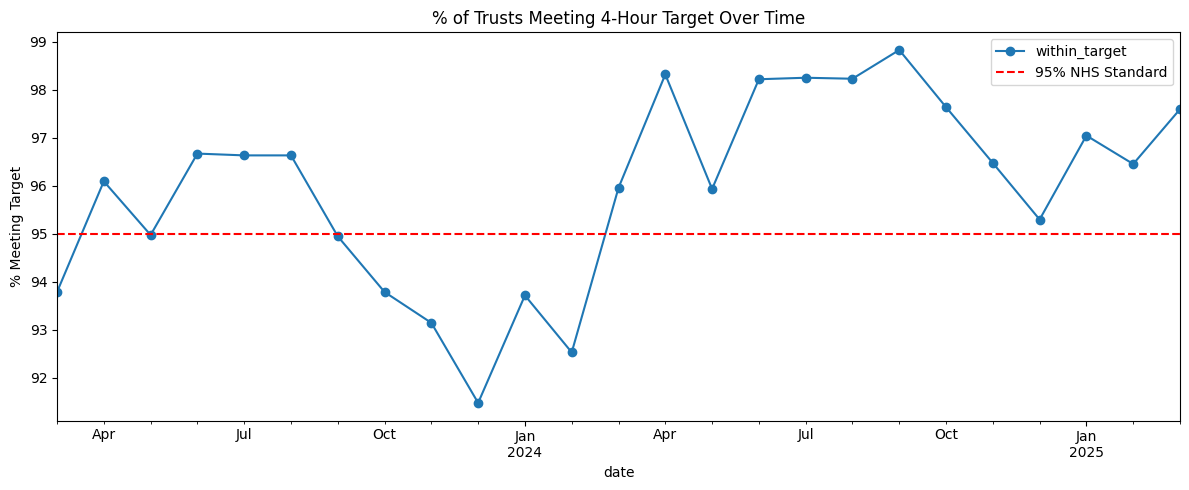

Overall % trusts meeting target: 95.9%


In [10]:
wait_times = ae_quality[ae_quality['MEASURE_NAME'] == 'TOTAL_TIME_MEDIAN'].copy()
wait_times['within_target'] = wait_times['MEASURE_VALUE'] <= 240

pct_within_target = wait_times.groupby('date')['within_target'].mean() * 100

plt.figure(figsize=(12, 5))
pct_within_target.plot(marker='o')
plt.title('% of Trusts Meeting 4-Hour Target Over Time')
plt.ylabel('% Meeting Target')
plt.axhline(y=95, color='r', linestyle='--', label='95% NHS Standard')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Overall % trusts meeting target: {wait_times['within_target'].mean()*100:.1f}%")


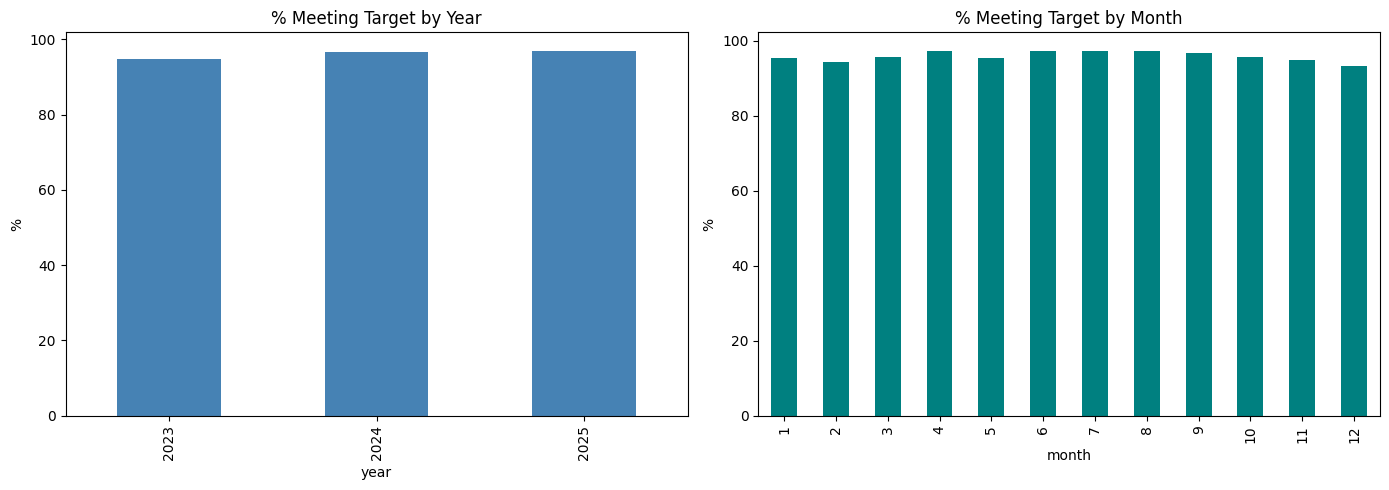

In [11]:
wait_times['year'] = wait_times['date'].dt.year
wait_times['month'] = wait_times['date'].dt.month

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
wait_times.groupby('year')['within_target'].mean().mul(100).plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('% Meeting Target by Year')
axes[0].set_ylabel('%')

wait_times.groupby('month')['within_target'].mean().mul(100).plot(kind='bar', ax=axes[1], color='teal')
axes[1].set_title('% Meeting Target by Month')
axes[1].set_ylabel('%')
plt.tight_layout()
plt.show()


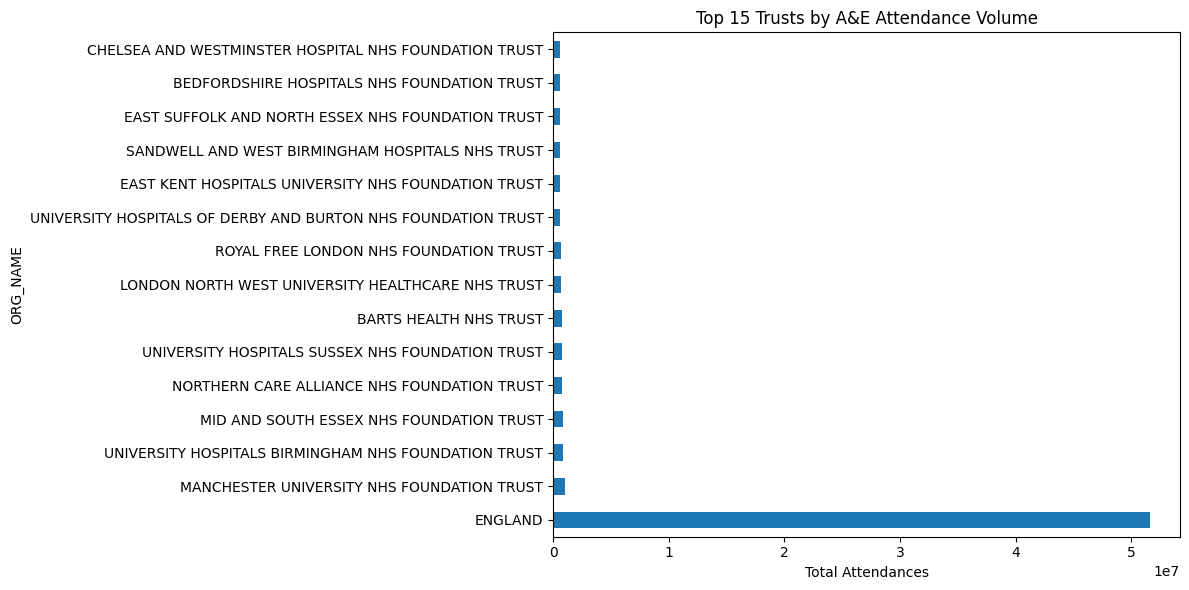

In [12]:
attendances = ae_quality[ae_quality['MEASURE_NAME'] == 'TOTAL_TIME_DENOM'].groupby('ORG_NAME')['MEASURE_VALUE'].sum()
top_volume = attendances.sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
top_volume.plot(kind='barh')
plt.xlabel('Total Attendances')
plt.title('Top 15 Trusts by A&E Attendance Volume')
plt.tight_layout()
plt.show()


In [13]:
wait_by_trust = ae_quality[ae_quality['MEASURE_NAME'] == 'TOTAL_TIME_MEDIAN'].groupby('ORG_NAME')['MEASURE_VALUE'].mean()
reattend_by_trust = ae_quality[ae_quality['MEASURE_NAME'] == 'UNPLANNED_REATTENDANCES_RATE'].groupby('ORG_NAME')['MEASURE_VALUE'].mean()

trust_metrics = pd.DataFrame({'wait_time': wait_by_trust, 'reattend_rate': reattend_by_trust}).dropna()

low_wait_threshold = trust_metrics['wait_time'].quantile(0.1)
low_reattend_threshold = trust_metrics['reattend_rate'].quantile(0.5)

best_trusts = trust_metrics[(trust_metrics['wait_time'] <= low_wait_threshold) &
                            (trust_metrics['reattend_rate'] <= low_reattend_threshold)]

print(f"Trusts in top 10% for wait times AND below-average reattendance:")
print(best_trusts.sort_values('wait_time'))


Trusts in top 10% for wait times AND below-average reattendance:
                                                    wait_time  reattend_rate
ORG_NAME                                                                    
DHU HEALTH CARE C.I.C                               21.350000       0.000000
LLR EA - THE MERLYN VAZ HEALTH & SOCIAL CARE CE...  24.958333       6.355424
URGENT TREATMENT CENTRE                             25.700000       0.000000
HEALTH & WELLBEING CENTRE                           27.500000       7.465597
DORSET HEALTHCARE UNIVERSITY NHS FOUNDATION TRUST   53.000000       3.208556
MALTON URGENT TREATMENT CENTRE                      53.142857       3.874863
BLACKPOOL VICTORIA URGENT CARE CENTRE               54.380000       0.000000
HUMBER TEACHING NHS FOUNDATION TRUST                55.360000       5.264975
PRACTICE PLUS GROUP HOSPITAL - SHEPTON MALLET       56.750000       0.958828
KENT COMMUNITY HEALTH NHS FOUNDATION TRUST          56.980000       7.441579
GLOUCESTERS

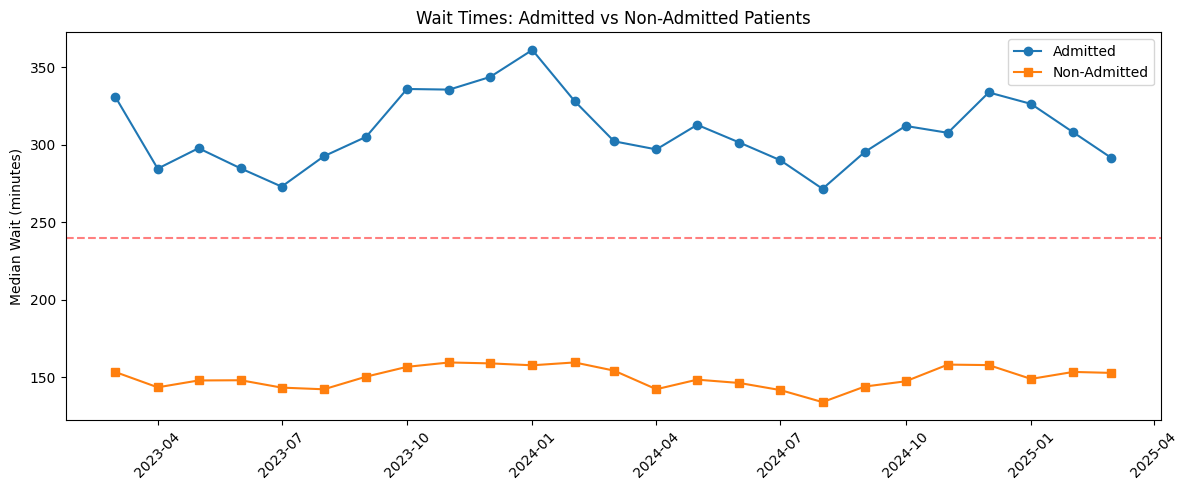

In [14]:
admitted = ae_quality[ae_quality['MEASURE_NAME'] == 'TOTAL_TIME_MEDIAN_ADMITTED'].groupby('date')['MEASURE_VALUE'].mean()
non_admitted = ae_quality[ae_quality['MEASURE_NAME'] == 'TOTAL_TIME_MEDIAN_NON_ADM'].groupby('date')['MEASURE_VALUE'].mean()

plt.figure(figsize=(12, 5))
plt.plot(admitted.index, admitted.values, label='Admitted', marker='o')
plt.plot(non_admitted.index, non_admitted.values, label='Non-Admitted', marker='s')
plt.axhline(y=240, color='r', linestyle='--', alpha=0.5)
plt.title('Wait Times: Admitted vs Non-Admitted Patients')
plt.ylabel('Median Wait (minutes)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


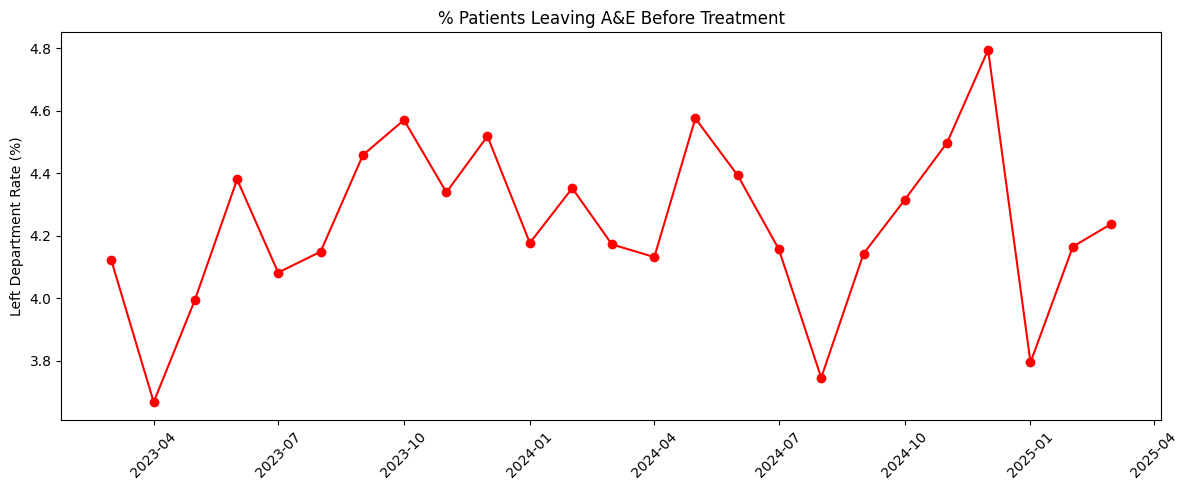

Average left-department rate: 4.24%


In [15]:
left_dept = ae_quality[ae_quality['MEASURE_NAME'] == 'LEFT_DEPARTMENT_ECDS_RATE'].groupby('date')['MEASURE_VALUE'].mean()

plt.figure(figsize=(12, 5))
plt.plot(left_dept.index, left_dept.values, marker='o', color='red')
plt.title('% Patients Leaving A&E Before Treatment')
plt.ylabel('Left Department Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"Average left-department rate: {left_dept.mean():.2f}%")


In [16]:
avg_emergency = consultation['APC_Emergency'].mean()
avg_outpatient = consultation['Outpatient_Total_Appointments'].mean()
print(f"Average monthly A&E emergency admissions: {avg_emergency:,.0f}")
print(f"Average monthly outpatient appointments: {avg_outpatient:,.0f}")


Average monthly A&E emergency admissions: 478,644
Average monthly outpatient appointments: 8,966,790


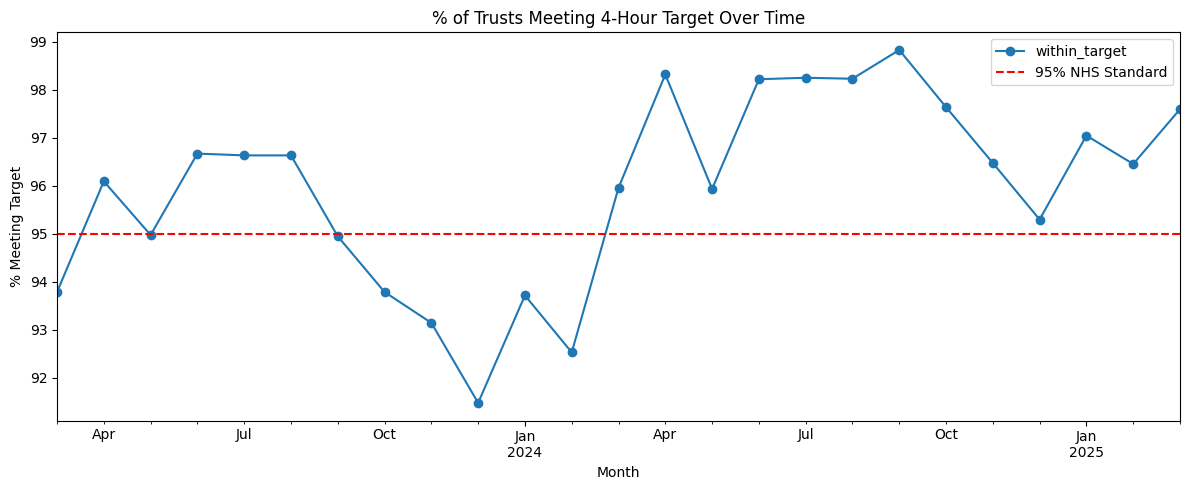


Overall % trusts meeting 4-hour target: 95.9%


In [17]:
wait_times = ae_quality[ae_quality['MEASURE_NAME'] == 'TOTAL_TIME_MEDIAN'].copy()
wait_times['within_target'] = wait_times['MEASURE_VALUE'] <= 240

pct_within_target = wait_times.groupby('date')['within_target'].mean() * 100

plt.figure(figsize=(12, 5))
pct_within_target.plot(marker='o')
plt.title('% of Trusts Meeting 4-Hour Target Over Time')
plt.ylabel('% Meeting Target')
plt.xlabel('Month')
plt.axhline(y=95, color='r', linestyle='--', label='95% NHS Standard')
plt.legend()
plt.tight_layout()
plt.show()

print(f"\nOverall % trusts meeting 4-hour target: {wait_times['within_target'].mean()*100:.1f}%")


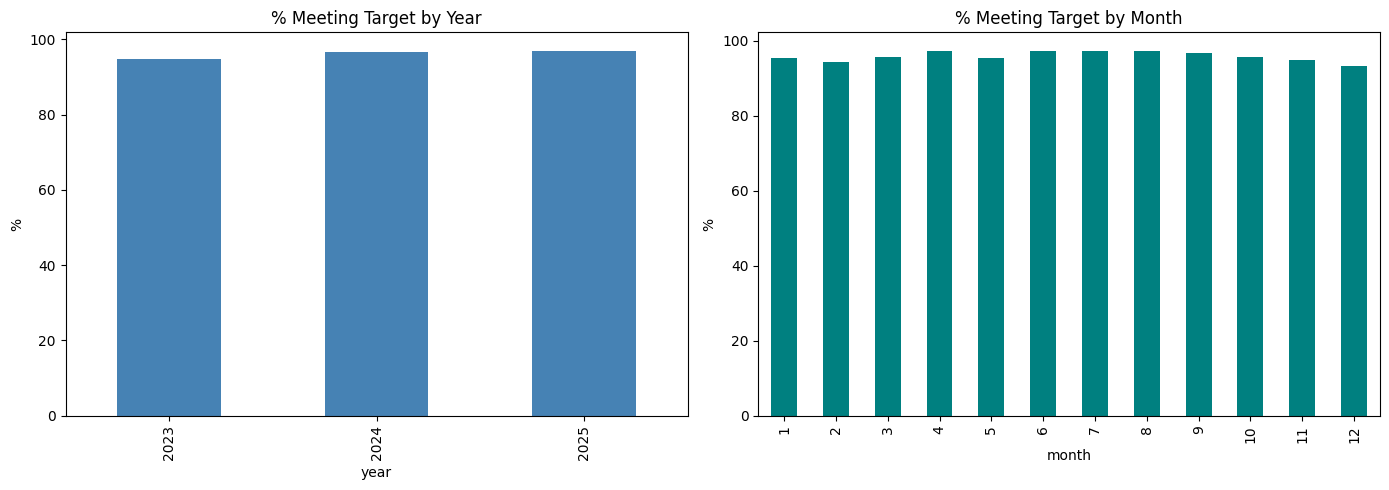

In [18]:
wait_times['year'] = wait_times['date'].dt.year
wait_times['month'] = wait_times['date'].dt.month

yearly_trend = wait_times.groupby('year')['within_target'].mean() * 100
monthly_trend = wait_times.groupby('month')['within_target'].mean() * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
yearly_trend.plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('% Meeting Target by Year')
axes[0].set_ylabel('%')

monthly_trend.plot(kind='bar', ax=axes[1], color='teal')
axes[1].set_title('% Meeting Target by Month')
axes[1].set_ylabel('%')
plt.tight_layout()
plt.show()
